# Analyzing Corporate Reputation through Sentiment Analysis on Tweets about Sustainability addressed to Google and Microsoft

By Karma, Fatih, and Leo

In [137]:
import os
import re
import csv
import importlib
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import snscrape
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, DataCollatorWithPadding, Trainer
from scipy.special import softmax
from datasets import load_metric, Dataset

### Defining Time Period and Sustainablity-related Hashtags 

In [2]:
companies = ['google','microsoft']
hashtags = ['sustainability', 'sustainable','environment', 'climatechange', 'csr', 'energy', 'renewables', 'sdg', 
            'sdgs', 'green', 'greenenergy', 'earthday', 'motherearth', 'renewableenergy', 'solarenergy', 'circulareconomy', 
            'climate', 'pollution', 'greenhouseeffect', 'greenhouse', 'carbondioxide', 'ozone', 'globalwarming', 'nature', 
            'climateaction', 'zerowaste', 'recycling']

time_range = pd.date_range(start=pd.to_datetime('2020-03-01'), end=pd.to_datetime('2022-02-28'))

months = pd.DataFrame({'date':time_range,'month':time_range.month, 'year':time_range.year}).groupby(['year','month'])['date'].agg(['min', 'max'])
n_months = len(months) 

n_tweets = (1000000 / (len(companies) * len(hashtags)) // n_months) + 1

print(f'For each month there will be up to {n_tweets} tweets collected per company and hashtag.')

For each month there will be up to 772.0 tweets collected per company and hashtag.


### Downloading Tweets through Twitter API

In [3]:
# for index, row in months.iterrows():
#     start_date = row['min'].strftime('%Y-%m-%d')
#     end_date = row['max'].strftime('%Y-%m-%d')
#     for company in companies:
#         for hashtag in hashtags:
#             file_name = start_date + '-' + company + '-' + hashtag
#             print(file_name)
#             os.system(f'snscrape --jsonl --max-results {str(int(n_tweets))} --since {start_date} twitter-search "@{company} #{hashtag} until:{end_date}"> {file_name}.json')

### Importing and Concatenating Data

In [4]:
df_google = pd.DataFrame(columns=['_type', 'url', 'date', 'content', 'renderedContent', 'id', 'user',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel',
       'outlinks', 'tcooutlinks', 'media', 'retweetedTweet', 'quotedTweet',
       'inReplyToTweetId', 'inReplyToUser', 'mentionedUsers', 'coordinates',
       'place', 'hashtags', 'cashtags'])
df_microsoft = pd.DataFrame(columns=['_type', 'url', 'date', 'content', 'renderedContent', 'id', 'user',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel',
       'outlinks', 'tcooutlinks', 'media', 'retweetedTweet', 'quotedTweet',
       'inReplyToTweetId', 'inReplyToUser', 'mentionedUsers', 'coordinates',
       'place', 'hashtags', 'cashtags'])

stats = pd.DataFrame(columns = ['time_period','company','hashtag','tweets_collected'])

for index, row in months.iterrows():
    start_date = row['min']
    
    for company in companies:
        
        for hashtag in hashtags:
            
            file_name = start_date.strftime('%Y-%m-%d') + '-' + company + '-' + hashtag
            tweets = pd.read_json(f'{file_name}.json', lines=True)
            stats = pd.concat([stats,
                pd.DataFrame(
                    {'time_period':start_date,'company':company,'hashtag':hashtag,'tweets_collected':len(tweets)}, 
                    index=[1])])
            
            if company=='google':
                df_google = pd.concat([df_google, tweets])

            elif company=='microsoft':
                df_microsoft = pd.concat([df_microsoft, tweets])
            
df_google = df_google.reset_index(drop=True)
df_microsoft = df_microsoft.reset_index(drop=True)
stats = stats.reset_index(drop=True)

### Data Cleaning

Duplicate tweets based on ID

In [5]:
df_google.id.duplicated().sum()

730

In [6]:
df_microsoft.id.duplicated().sum()

776

In [7]:
df_google = df_google.drop_duplicates('id').reset_index(drop=True)
df_microsoft = df_microsoft.drop_duplicates('id').reset_index(drop=True)

Data Cleaning Functions for Later Use in Pipelines

In [8]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def clean_tweet(tweet):
    # remove twitter Return handles (RT @xxx:)
    tweet = remove_pattern(tweet, "RT @[\w]*:") 
    
    # remove URLs
    tweet = remove_pattern(tweet, "https?://[A-Za-z0-9./]*")
    
    # remove '#'
    tweet = tweet.replace("#","")
    
    # remove '@'
    tweet = tweet.replace("@","")
    
    # remove '\n'
    tweet = tweet.replace("\n"," ")
    
    # replace '&amp' with and
    tweet = tweet.replace("&amp;","and")
    
    return tweet

### Exploratory Data Analysis

In [9]:
len(df_google)

2865

In [10]:
len(df_microsoft)

3779

In [11]:
total_tweets = len(df_google) + len(df_microsoft)
total_tweets

6644

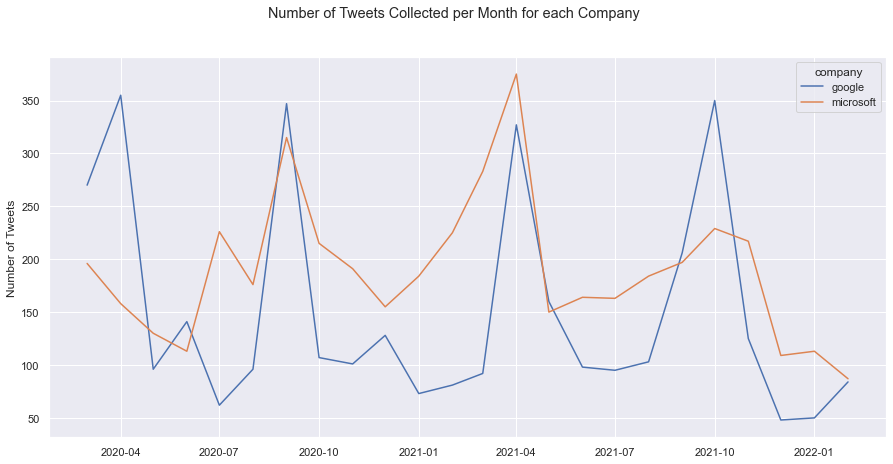

In [12]:
sns.set()
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(data=stats.groupby(['time_period','company'], as_index=False)['tweets_collected'].agg(['sum']),x='time_period',y='sum',hue='company')
plt.xlabel('')
plt.ylabel('Number of Tweets')
fig.suptitle('Number of Tweets Collected per Month for each Company');

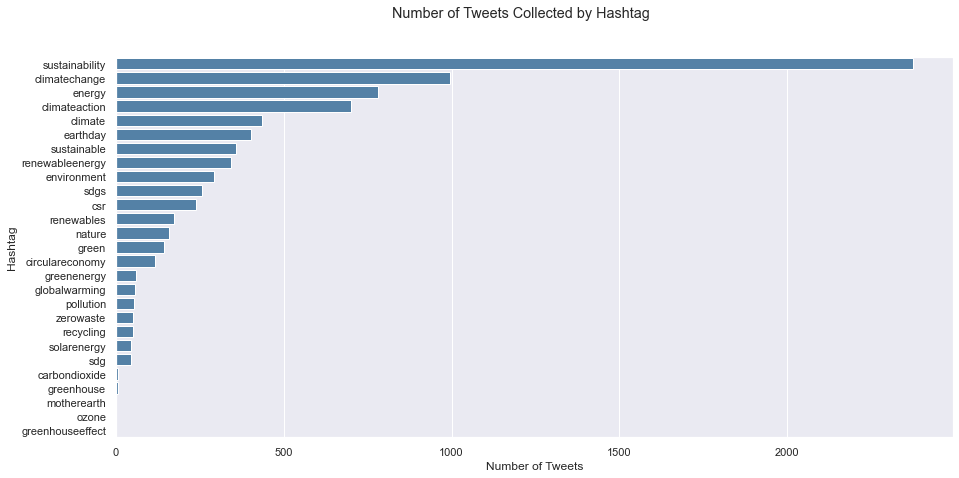

In [13]:
sns.set()
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(data=stats.groupby(['hashtag'], as_index=False)['tweets_collected'].agg(['sum']).sort_values(by='sum',ascending=False).reset_index(),x='sum',y='hashtag',color='steelblue')
plt.xlabel('Number of Tweets')
plt.ylabel('Hashtag')
fig.suptitle('Number of Tweets Collected by Hashtag');

### Sampling for Annotation

#### Export sample

In [14]:
google_sample = df_google.sample(250, random_state=123)
microsoft_sample = df_microsoft.sample(250, random_state=123)

In [15]:
google_sample[['id','content']].to_csv('google_sample.csv')
microsoft_sample[['id','content']].to_csv('microsoft_sample.csv')

#### Import annotated

In [224]:
google_true = pd.read_csv('google_sample_annotated.csv',sep=';')
google_true.columns = ['index','id','content','true_label']
google_true = google_true.drop('index',axis=1)
conversion = {'Negative':-1,'Neutral':0,'Positive':1,'nega':-1}
google_true = google_true.replace({'true_label':conversion})

In [225]:
microsoft_true = pd.read_csv('microsoft_sample_annotated.csv')
microsoft_true.columns = ['index','id','content','true_label']
microsoft_true = microsoft_true.drop('index',axis=1)
conversion = {'Negative':-1,'Neutral':0,'Positive':1}
microsoft_true = microsoft_true.replace({'true_label':conversion})
microsoft_true['id'] = list(microsoft_sample['id'])

## Base Model: VADER Sentiment Analysis

In [221]:
def vader(df):
    vader = SentimentIntensityAnalyzer()
    vader_sentiment_scores = pd.DataFrame(columns=['neg','neu','pos','compound','label'])
    for i, row in df[['id','content']].iterrows():
        sent = pd.DataFrame(vader.polarity_scores(clean_tweet(row.content)),index=[row.id])
        if sent.compound[row.id] >= 0.1: 
            sent['label'] = 1
        elif sent.compound[row.id] <= -0.1:
            sent['label'] = -1
        else:
            sent['label'] = 0
        vader_sentiment_scores = pd.concat([vader_sentiment_scores,sent])
    return vader_sentiment_scores

In [222]:
google_vader_sentiment_scores = vader(df_google)

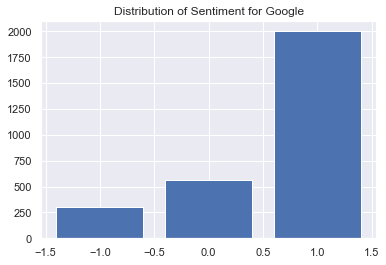

In [218]:
g_bar_data = pd.DataFrame(google_vader_sentiment_scores.label.value_counts())
plt.bar(g_bar_data.index,g_bar_data.label)
plt.title('Distribution of Sentiment for Google');

In [223]:
microsoft_vader_sentiment_scores = vader(df_microsoft)

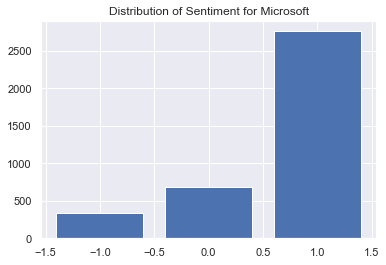

In [21]:
m_bar_data = pd.DataFrame(microsoft_vader_sentiment_scores.label.value_counts())
plt.bar(m_bar_data.index,m_bar_data.label)
plt.title('Distribution of Sentiment for Microsoft');

#### Sentiment Score

- Positives = 1
- Negatives = -1

Overall Sentiment Score = ((Positives + Retweets + Likes/2) - (Negatives - Retweets - Likes/2)) / Count of Both

In [101]:
def overall_sentiment(df):
    label = df.label
    labels = label[label!=0] # remove neutral tweets
    retweetCount = df.retweetCount[label!=0]
    likeCount = df.likeCount[label!=0]
    
    total = 0
    score = []
    for i in range(len(labels)):
        if labels[i] > 0: # if positive add up
            s = labels[i] + retweetCount[i] + (likeCount[i] / 2)
            total += s
            score.append(s)
        elif labels[i] < 0: # if negative subtract
            s = labels[i] - retweetCount[i] - (likeCount[i] / 2)
            total += (s*-1)
            score.append(s)
    return np.sum(score) / total # return sum of sentiment and normalize

In [102]:
vader_df_google = df_google[['id','date','content','replyCount','retweetCount','likeCount']].copy(deep=True)
vader_df_google = vader_df_google.merge(google_vader_sentiment_scores.reset_index(), left_on='id', right_on='index')
vader_df_google = vader_df_google.drop('index',axis=1).set_index('date')

print('Google Overall Sentiment Score:', np.round(overall_sentiment(vader_df_google),2))

Google Overall Sentiment Score: 0.79


In [103]:
vader_df_microsoft = df_microsoft[['id','date','content','replyCount','retweetCount','likeCount']].copy(deep=True)
vader_df_microsoft = vader_df_microsoft.merge(microsoft_vader_sentiment_scores.reset_index(), left_on='id', right_on='index')
vader_df_microsoft = vader_df_microsoft.drop('index',axis=1).set_index('date')

print('Microsoft Overall Sentiment Score:', np.round(overall_sentiment(vader_df_microsoft),2))

Microsoft Overall Sentiment Score: 0.71


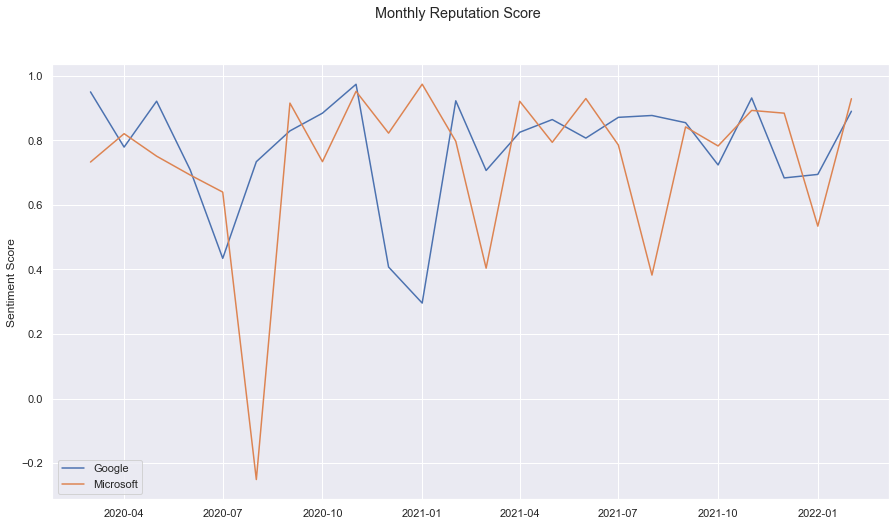

In [135]:
def calc_time_series(df, months):
    ts = []
    for year, month in months.index:
        ts.append(overall_sentiment(df[(df.index.year==year)&(df.index.month==month)]))
    return pd.DataFrame({'min':months['min'],'label':ts})

ts_google = calc_time_series(vader_df_google, months)
ts_microsoft = calc_time_series(vader_df_microsoft, months)

fig, ax = plt.subplots(figsize=(15,8))
plt.plot(ts_google['min'],ts_google['label'],label='Google')
plt.plot(ts_microsoft['min'],ts_microsoft['label'],label='Microsoft')
plt.legend()
plt.xlabel('')
plt.ylabel('Sentiment Score')
fig.suptitle('Monthly Reputation Score');

#### Evaluation: Micro F1-Score

In [122]:
vader_google_eval = vader_df_google[['id','label']].merge(google_sample['id'], on='id')
vader_google_eval = vader_google_eval.merge(google_true[['id','true_label']], on='id')
f1_score(vader_google_eval.true_label.astype('str'), vader_google_eval.label.astype('str'), average='micro')

0.492

In [123]:
vader_microsoft_eval = vader_df_microsoft[['id','label']].merge(microsoft_sample['id'], on='id')
vader_microsoft_eval = vader_microsoft_eval.merge(microsoft_true[['id','true_label']], on='id')
f1_score(microsoft_true.true_label.astype('str'), vader_microsoft_eval.label.astype('str'), average='micro')

0.5

## Twitter roBerta Base Sentiment

### Google

In [251]:
def berta_quickshot(df):
    
    MODEL = 'cardiffnlp/twitter-roberta-base-sentiment'
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)

    berta_sentiment_scores = pd.DataFrame(columns=['neg','neu','pos','label'])

    for i, row in df[['id','content']].iterrows():

        # preprocess
        text = clean_tweet(row.content)
        encoded_input = tokenizer(text, return_tensors='pt')

        # model
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)

        # scores to label
        argmax = np.argmax(scores)
        if argmax == 0: label = -1
        elif argmax == 1: label = 0
        else: label = 1

        # save to df
        sent = pd.DataFrame({'neg':scores[0],'neu':scores[1],'pos':scores[2],'label':label},index=[row.id])
        berta_sentiment_scores = pd.concat([berta_sentiment_scores,sent])
        
    return berta_sentiment_scores

In [252]:
google_berta_sentiment_scores = berta_quickshot(df_google)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json from cache at C:\Users\leofr/.cache\huggingface\transformers\7dd97280b5338fb674b5372829a05a1aaaa76f9f2fa71c36199f2ce1ee1104a0.4c7ca95b4fd82b8bbe94fde253f5f82e5a4eedefe6f86f6fa79efc903d6cfe60
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "laye

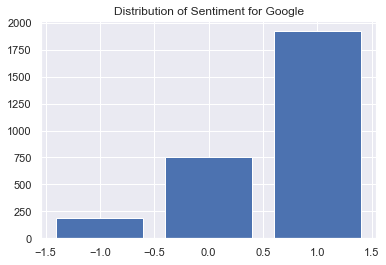

In [253]:
g_bar_data = pd.DataFrame(google_berta_sentiment_scores.label.value_counts())
plt.bar(g_bar_data.index,g_bar_data.label)
plt.title('Distribution of Sentiment for Google');

In [254]:
berta_df_google = df_google[['id','date','content','replyCount','retweetCount','likeCount']].copy(deep=True)
berta_df_google = berta_df_google.merge(google_berta_sentiment_scores.reset_index(), left_on='id', right_on='index')
berta_df_google = berta_df_google.drop('index',axis=1).set_index('date')
print('Google Overall Sentiment Score:', np.round(overall_sentiment(berta_df_google),2))

Google Overall Sentiment Score: 0.89


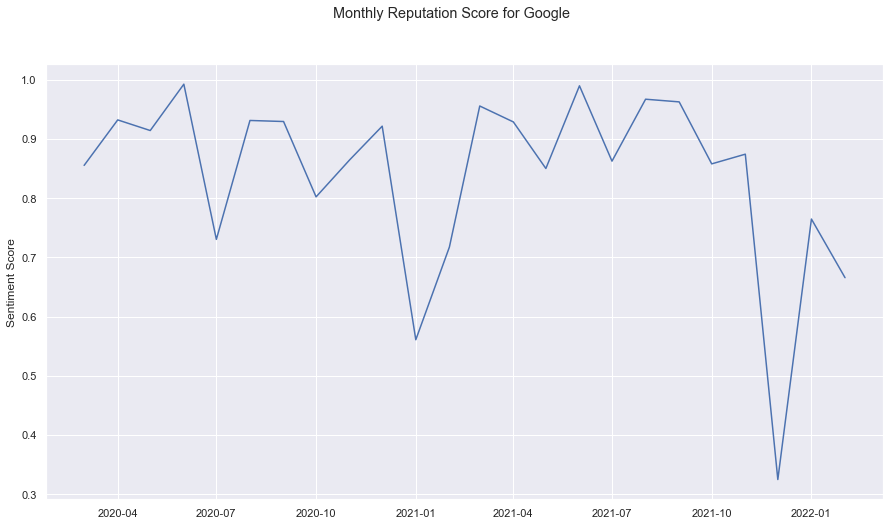

In [134]:
ts_google = calc_time_series(berta_df_google, months)

fig, ax = plt.subplots(figsize=(15,8))
plt.plot(ts_google['min'],ts_google['label'])
plt.xlabel('')
plt.ylabel('Sentiment Score')
fig.suptitle('Monthly Reputation Score for Google');

In [127]:
berta_google_eval = berta_df_google[['id','label']].merge(google_sample['id'], on='id')
berta_google_eval = berta_google_eval.merge(google_true[['id','true_label']], on='id')
print('Google F1-Score:', f1_score(berta_google_eval.true_label.astype('str'), berta_google_eval.label.astype('str'), average='micro'))

Google F1-Score: 0.6


### Microsoft

In [255]:
microsoft_berta_sentiment_scores = berta_quickshot(df_microsoft)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json from cache at C:\Users\leofr/.cache\huggingface\transformers\7dd97280b5338fb674b5372829a05a1aaaa76f9f2fa71c36199f2ce1ee1104a0.4c7ca95b4fd82b8bbe94fde253f5f82e5a4eedefe6f86f6fa79efc903d6cfe60
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "laye

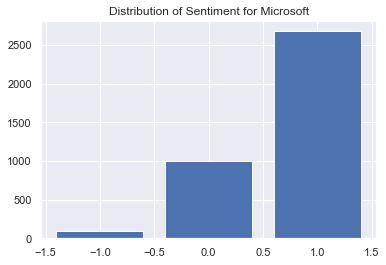

In [256]:
m_bar_data = pd.DataFrame(microsoft_berta_sentiment_scores.label.value_counts())
plt.bar(m_bar_data.index,m_bar_data.label)
plt.title('Distribution of Sentiment for Microsoft');

In [257]:
berta_df_microsoft = df_microsoft[['id','date','content','replyCount','retweetCount','likeCount']].copy(deep=True)
berta_df_microsoft = berta_df_microsoft.merge(microsoft_berta_sentiment_scores.reset_index(), left_on='id', right_on='index')
berta_df_microsoft = berta_df_microsoft.drop('index',axis=1).set_index('date')
print('Microsoft Overall Sentiment Score:', np.round(overall_sentiment(berta_df_microsoft),2))

Microsoft Overall Sentiment Score: 0.93


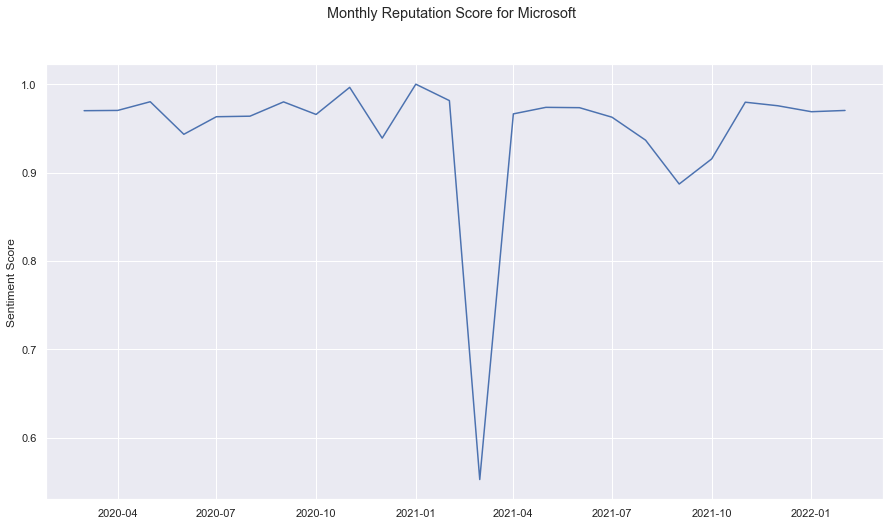

In [133]:
ts_microsoft = calc_time_series(berta_df_microsoft, months)

fig, ax = plt.subplots(figsize=(15,8))
plt.plot(ts_microsoft['min'],ts_microsoft['label'])
plt.xlabel('')
plt.ylabel('Sentiment Score')
fig.suptitle('Monthly Reputation Score for Microsoft');

In [130]:
ts_microsoft.reset_index().to_csv('microsoft_sentiment_over_time.csv')
ts_google.reset_index().to_csv('google_sentiment_over_time.csv')

In [258]:
berta_microsoft_eval = berta_df_microsoft[['id','label']].merge(microsoft_sample['id'], on='id')
berta_microsoft_eval = berta_microsoft_eval.merge(microsoft_true[['id','true_label']], on='id')
print('Microsoft F1-Score:', f1_score(berta_microsoft_eval.true_label.astype('str'), berta_microsoft_eval.label.astype('str'), average='micro'))

Microsoft F1-Score: 0.596


### Fine-tuning

In [138]:
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

labels

['negative', 'neutral', 'positive']

#### Google

In [179]:
google_train = google_true[['content','true_label']]
google_train.columns =['content','label']

google_train['text'] = [clean_tweet(tweet) for tweet in google_train.content]
google_train = google_train.drop('content',axis=1)

berta_labels = {-1:0,0:1,1:2}
google_train = google_train.replace({'label':berta_labels})

google_train = Dataset.from_pandas(google_train)
google_train = google_train.train_test_split(test_size=0.2,seed=123)

google_train

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 200
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50
    })
})

In [190]:
MODEL = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer_tune = AutoTokenizer.from_pretrained(MODEL)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_tune)
model_tune = AutoModelForSequenceClassification.from_pretrained(MODEL)

metric = load_metric('accuracy')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json from cache at C:\Users\leofr/.cache\huggingface\transformers\7dd97280b5338fb674b5372829a05a1aaaa76f9f2fa71c36199f2ce1ee1104a0.4c7ca95b4fd82b8bbe94fde253f5f82e5a4eedefe6f86f6fa79efc903d6cfe60
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "laye

In [191]:
def preprocess_function(examples):
    return tokenizer_tune(examples['text'], padding='max_length', truncation=True, max_length=280)

google_train_t = google_train.map(preprocess_function, batched=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.66ba/s]


In [192]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [193]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model_tune,
    args=training_args,
    train_dataset=google_train_t['train'],
    eval_dataset=google_train_t['test'],
    tokenizer=tokenizer_tune,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [194]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\leofr\miniconda3\envs\NLP2\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 200
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 65


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=65, training_loss=0.42846307020920976, metrics={'train_runtime': 2335.933, 'train_samples_per_second': 0.428, 'train_steps_per_second': 0.028, 'total_flos': 143890150320000.0, 'train_loss': 0.42846307020920976, 'epoch': 5.0})

In [239]:
predictions = trainer.predict(google_train_t['test'])
preds = np.argmax(predictions.predictions, axis=-1)
preds

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 50
  Batch size = 16


array([1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 0, 2, 2, 1, 1, 1, 0, 2, 1, 2, 2,
       2, 0, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2,
       0, 1, 1, 2, 0, 2], dtype=int64)

In [240]:
preds= pd.Series(preds)
google_test_val = pd.Series(google_train['test']['label'])
print('Google F1-Score:', f1_score(google_test_val.astype('str'), preds.astype('str'), average='micro'))

Google F1-Score: 0.72


#### Microsoft

In [208]:
microsoft_train = microsoft_true[['content','true_label']]
microsoft_train.columns =['content','label']

microsoft_train['text'] = [clean_tweet(tweet) for tweet in microsoft_train.content]
microsoft_train = microsoft_train.drop('content',axis=1)

berta_labels = {-1:0,0:1,1:2}
microsoft_train = microsoft_train.replace({'label':berta_labels})

microsoft_train = Dataset.from_pandas(microsoft_train)
microsoft_train = microsoft_train.train_test_split(test_size=0.2,seed=123)

microsoft_train

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 200
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50
    })
})

In [211]:
MODEL2 = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer_tune2 = AutoTokenizer.from_pretrained(MODEL2)
data_collator2 = DataCollatorWithPadding(tokenizer=tokenizer_tune2)
model_tune2 = AutoModelForSequenceClassification.from_pretrained(MODEL2)

metric = load_metric('accuracy')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json from cache at C:\Users\leofr/.cache\huggingface\transformers\7dd97280b5338fb674b5372829a05a1aaaa76f9f2fa71c36199f2ce1ee1104a0.4c7ca95b4fd82b8bbe94fde253f5f82e5a4eedefe6f86f6fa79efc903d6cfe60
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "laye

In [210]:
microsoft_train_t = microsoft_train.map(preprocess_function, batched=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45ba/s]


In [213]:
training_args2 = TrainingArguments(
    output_dir="./results2",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer2 = Trainer(
    model=model_tune2,
    args=training_args2,
    train_dataset=microsoft_train_t['train'],
    eval_dataset=microsoft_train_t['test'],
    tokenizer=tokenizer_tune2,
    data_collator=data_collator2,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [214]:
trainer2.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\leofr\miniconda3\envs\NLP2\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 200
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 65


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=65, training_loss=0.6633263808030349, metrics={'train_runtime': 1476.3987, 'train_samples_per_second': 0.677, 'train_steps_per_second': 0.044, 'total_flos': 143890150320000.0, 'train_loss': 0.6633263808030349, 'epoch': 5.0})

In [241]:
predictions2 = trainer2.predict(microsoft_train_t['test'])
preds2 = np.argmax(predictions2.predictions, axis=-1)
preds2

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 50
  Batch size = 16


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2], dtype=int64)

In [242]:
preds2= pd.Series(preds2)
microsoft_test_val = pd.Series(microsoft_train['test']['label'])
print('Microsoft F1-Score:', f1_score(microsoft_test_val.astype('str'), preds2.astype('str'), average='micro'))

Microsoft F1-Score: 0.56


### Comparing F-1 Scores

In [231]:
pred_df_google = pd.DataFrame({'id':np.arange(0,50),'content':google_train['test']['text']})
pred_df_microsoft = pd.DataFrame({'id':np.arange(0,50),'content':microsoft_train['test']['text']})

In [264]:
vader_google_pred = vader(pred_df_google).label.replace({-1:0,0:1,1:2})
vader_microsoft_pred = vader(pred_df_microsoft).label.replace({-1:0,0:1,1:2})
roberta_google_pred = berta_quickshot(pred_df_google).label.replace({-1:0,0:1,1:2})
roberta_microsoft_pred = berta_quickshot(pred_df_microsoft).label.replace({-1:0,0:1,1:2})

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json from cache at C:\Users\leofr/.cache\huggingface\transformers\7dd97280b5338fb674b5372829a05a1aaaa76f9f2fa71c36199f2ce1ee1104a0.4c7ca95b4fd82b8bbe94fde253f5f82e5a4eedefe6f86f6fa79efc903d6cfe60
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "laye

loading file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/vocab.json from cache at C:\Users\leofr/.cache\huggingface\transformers\089d0f043cfdb86b4f4d79238552b1dcd5b791d4be7c48f27bd7323bdbb7c599.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
loading file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/merges.txt from cache at C:\Users\leofr/.cache\huggingface\transformers\45449f1b6476a9fe84f9eade7f45745cdea8af6b3735f760d8bb0f4b71adf57f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/special_tokens_map.json from cache at C:\Users\leofr/.cache\huggingfac

In [266]:
f1_table = pd.DataFrame({
    'Models':['Vader Google','Vader Microsoft',
              'Roberta Google','Roberta Microsoft',
              'Roberta Google Finetune','Roberta Microsoft Finetune'],
    'Micro-Average F1':[f1_score(google_test_val.astype('str'), vader_google_pred.astype('str'), average='micro'),
                        f1_score(microsoft_test_val.astype('str'), vader_microsoft_pred.astype('str'), average='micro'),
                        f1_score(google_test_val.astype('str'), roberta_google_pred.astype('str'), average='micro'),
                        f1_score(microsoft_test_val.astype('str'), roberta_microsoft_pred.astype('str'), average='micro'),
                        f1_score(microsoft_test_val.astype('str'), preds.astype('str'), average='micro'),
                        f1_score(microsoft_test_val.astype('str'), preds2.astype('str'), average='micro')
                       ]})

f1_table

,Models,Micro-Average F1
0,Vader Google,0.46
1,Vader Microsoft,0.48
2,Roberta Google,0.62
3,Roberta Microsoft,0.52
4,Roberta Google Finetune,0.42
5,Roberta Microsoft Finetune,0.56
